# Entraînement d'un CNN pour détecter le port du masque

In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Conv2D, experimental, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential

## Import des données d'entraînement et de test et retraitement des images

### Train set

In [55]:
with_train = [cv2.imread(file, 3) for file in glob.glob("Dataset_masks/train/with_mask/*.jpg")]

In [56]:
wout_train = [cv2.imread(file, 3) for file in glob.glob("Dataset_masks/train/without_mask/*.jpg")]

In [57]:
for i in range(len(with_train)):
    with_train[i] = cv2.resize(with_train[i], (100,100))
for i in range(len(wout_train)):
    wout_train[i] = cv2.resize(wout_train[i], (100,100))

(100, 100, 3)


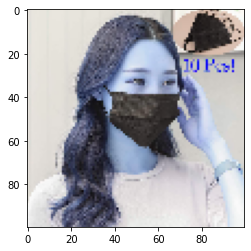

In [58]:
print(with_train[15].shape)
plt.imshow(with_train[15])

In [32]:
X_train= np.concatenate((np.asarray(with_train, dtype=list), np.asarray(wout_train, dtype=list)), axis=0)

In [33]:
print(X_train.shape)

(1306, 100, 100, 3)


In [34]:
y_with_train = np.ones((len(with_train), 1), dtype = int)
y_wout_train = np.zeros((len(wout_train), 1), dtype = int)

y_train = np.concatenate((y_with_train, y_wout_train))

In [35]:
print(y_train.shape)

(1306, 1)


In [36]:
index = np.random.permutation([i for i in range(len(y_train))])
print(len(index))

1306


In [37]:
X_train = X_train[index]
y_train = y_train[index]

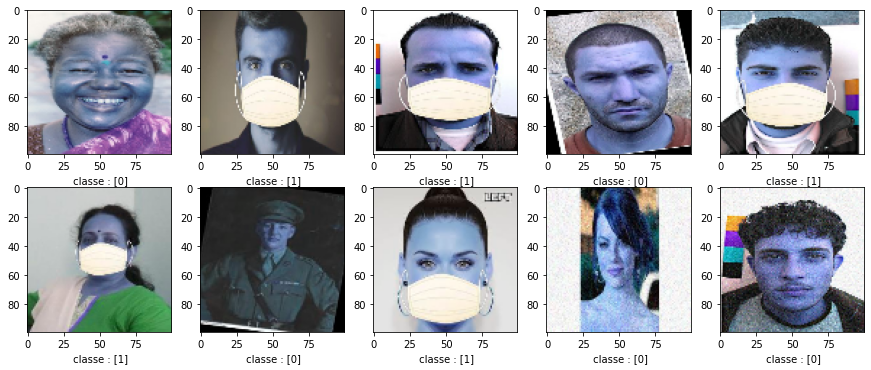

In [38]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow( np.uint8(X_train[i]), cmap='gray')
    plt.xlabel(" classe : {}".format(y_train[i]))
plt.show()


In [39]:
X_train[0].shape

(100, 100, 3)

### Test set

In [41]:
## meme chose pour le test_set

with_test = [cv2.imread(file) for file in glob.glob("Dataset_masks/test/with_mask/*.jpg")]
wout_test = [cv2.imread(file) for file in glob.glob("Dataset_masks/test/without_mask/*.jpg")]

for i in range(len(with_test)):
    with_test[i] = cv2.resize(with_test[i], (100,100))
for i in range(len(wout_test)):
    wout_test[i] = cv2.resize(wout_test[i], (100,100))
    
X_test= np.concatenate((np.asarray(with_test, dtype=list), np.asarray(wout_test, dtype=list)), axis=0)

y_with_test = np.ones((len(with_test), 1), dtype = int)
y_wout_test = np.zeros((len(wout_test), 1), dtype = int)

y_test = np.concatenate((y_with_test, y_wout_test))

index = np.random.permutation([i for i in range(len(y_test))])

X_test = X_test[index]
y_test = y_test[index]

## Pré-traitement des données

### Standardisation

In [43]:
# la veleur de chaque pixel sera située entre 0 et 1

X_train = X_train.astype('float') / 255
X_test = X_test.astype('float') / 255

### Redimensionnement

In [45]:
X_train = X_train.reshape(len(X_train),100,100,3)
X_test = X_test.reshape(len(X_test),100,100,3)
# on redimensionne les X pour qu'ils puissent être passés en argument input_shape de Conv2D.
# conv2D travaille avec des images qui ont une hauteur, une largeur et un shema de couleur (1 pour greyscale, 3 pour RGB)

In [49]:
#implémentation du modèle séquentiel 2
model2 = models.Sequential()

model2.add(Conv2D(32, 3, padding="same", activation='relu', input_shape=(100,100,3)))
model2.add(Conv2D(32, 3, padding="same", activation='relu'))
model2.add(MaxPooling2D(2))
model2.add(Conv2D(128, 3, padding="same", activation='relu'))
model2.add(Conv2D(128, 3, padding="same", activation='relu'))
model2.add(MaxPooling2D(2))
model2.add(Flatten())
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.25))
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))


In [50]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 128)       36992     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)            

In [51]:
model2.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=3, batch_size=5, validation_split=0.2, verbose=True)

y_pred2 = (model2.predict(X_test) >0.5).astype("int32")
print(confusion_matrix(y_test, y_pred2), "accuracy score :", accuracy_score(y_test, y_pred2))

Epoch 1/3
209/209 [==============================] - 94s 444ms/step - loss: 0.6396 - accuracy: 0.6121 - val_loss: 0.2245 - val_accuracy: 0.9008
Epoch 2/3
209/209 [==============================] - 93s 444ms/step - loss: 0.2424 - accuracy: 0.9112 - val_loss: 0.1229 - val_accuracy: 0.9618
Epoch 3/3
209/209 [==============================] - 87s 414ms/step - loss: 0.2104 - accuracy: 0.9446 - val_loss: 0.2082 - val_accuracy: 0.9237
[[94  3]
 [ 5 92]] accuracy score : 0.9587628865979382


In [53]:
model2.save('masque_model')

INFO:tensorflow:Assets written to: masque_model\assets
